In [46]:
#pip install numpy==1.19, tensorflow==2.3.0

In [47]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import math 

from tensorflow import keras
from scipy.stats import norm
from numpy.polynomial.hermite import hermgauss

import matplotlib.pyplot as plt

import urllib
import os

np.random.seed(42)

from DeepPDE.Classes.DPDEGenerator  import DPDEGenerator
from DeepPDE.Classes.DPEDEModel  import DPDEModel
from DeepPDE.Classes.HighwayLayer import *
from DeepPDE.tools.others import *

np.random.seed(42)


In [48]:

nr_samples_surface_plot = 21
nr_samples_scatter_plot = 1000
nr_samples_error_calculation = 10000



In [74]:
nr_nodes_per_layer = 90
initial_learning_rate = 0.001
localisation_parameter = 1/10.

n_train = 10
nr_epochs = 601

## Assets d=2

In [50]:
# Model parameters. Re-train model after any changes.
s_min_interest = 25
s_max_interest = 150
t_min_interest = 0.5
t_max_interest = 4.

riskfree_rate_min = 0.1
riskfree_rate_max = 0.3
riskfree_rate_eval = 0.2

volatility_min = 0.1
volatility_max = 0.3
volatility1_eval = 0.1
volatility2_eval = 0.3

correlation_min = 0.2
correlation_max = 0.8
correlation_eval = 0.5

strike_price = 100.

In [51]:
dimension_states =2  
dimension_parameter =4
dimension_totale= 1+ dimension_states +dimension_parameter



In [52]:
normalise =transform(0,t_max=t_max, strike_price=strike,volatility_min= volatility_min,
                     volatility_max= volatility_max,normalise_min=normalised_min,normalise_max=normalised_max,r_min=riskfree_rate_min,
                     r_max= riskfree_rate_max,rho_min= correlation_min,rho_max= correlation_max)






riskfree_rate_eval_normalised = normalise.normalise_riskfree_rate(riskfree_rate_eval)
volatility1_eval_normalised = normalise.normalise_volatility(volatility1_eval)
volatility2_eval_normalised = normalise.normalise_volatility(volatility2_eval)
correlation_eval_normalised = normalise.normalise_correlation(correlation_eval)

In [76]:
%%time
load_model = False
if load_model:
    # Load model from local folder. If it is not availabe, download it.
    os.makedirs('model/variables', exist_ok=True)
    url_base = 'https://github.com/LWunderlich/DeepPDE/raw/main/TwoAssetsExample/'
    filename = 'model/saved_model.pb'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)
        
    filename = 'model/variables/variables.data-00000-of-00001'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    filename = 'model/variables/variables.index'
    if not os.path.isfile(filename):
        urllib.request.urlretrieve(url_base + filename, filename)

    model = keras.models.load_model('model')   
else:
    # Create and train model from scratch. 
    
    inputs = keras.Input(shape=(dimension_totale,))
    outputs = create_network(inputs,nr_nodes_per_layer,localisation_parameter,dimension_totale)
    model = DPDEModel(inputs=inputs, outputs=outputs) 
    batch_generator = DPDEGenerator(n_train,normalised_min,normalised_max,dimension_states, dimension_parameter)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(initial_learning_rate))
    callback = tf.keras.callbacks.EarlyStopping('loss', patience=50, restore_best_weights=True)



    callbacksaving = tf.keras.callbacks.ModelCheckpoint( "../DeepPDE/DeepPDE/tools/cp.ckpt",
                                 monitor='loss', 
                                 verbose=0, 
                                 save_best_only=True,
                                 save_weights_only=True, 
                                 mode='auto', 
                                 save_freq='epoch')

history= model.fit(x=batch_generator, epochs=nr_epochs, steps_per_epoch=10,
                          callbacks=[callback, callbacksaving])

Epoch 1/601
10/10 [==============================] - 0s 20ms/step - loss: 407.3964 - loss initial: 386.0486 - loss interior: 21.3479
Epoch 2/601
10/10 [==============================] - 0s 21ms/step - loss: 414.4482 - loss initial: 396.3104 - loss interior: 18.1378
Epoch 3/601
10/10 [==============================] - 0s 13ms/step - loss: 561.5361 - loss initial: 544.6596 - loss interior: 16.8765
Epoch 4/601
10/10 [==============================] - 0s 19ms/step - loss: 336.3887 - loss initial: 318.0865 - loss interior: 18.3022
Epoch 5/601
10/10 [==============================] - 0s 12ms/step - loss: 3071.3654 - loss initial: 373.8118 - loss interior: 2697.5536
Epoch 6/601
10/10 [==============================] - 0s 18ms/step - loss: 396.2109 - loss initial: 375.1632 - loss interior: 21.0476
Epoch 7/601
10/10 [==============================] - 0s 14ms/step - loss: 824.5617 - loss initial: 265.5644 - loss interior: 558.9973
Epoch 8/601
10/10 [==============================] - 0s 16ms/step

In [54]:
#from DeepPDE.tools.others

test_solution = exact_solution(t=4., s1=100., s2=100., riskfree_rate=0.2, 
               volatility1=0.1, volatility2=0.3, correlation=0.5)

assert(np.abs(test_solution - 55.096796282039364) < 1e-1)


In [55]:
sigma =np.array([0.01, 0.015, 0.015, 0.09]).reshape((2,2))
s=[100,200]

test = exact_solution2(t=4, s=s, sigma=sigma, riskfree_rate=0.2, dimension_states=2)

In [56]:
s1_plot_mesh, s2_plot_mesh, x_plot_normalised =get_points_for_plot_at_fixed_time(t_fixed=t_max, s_min_interest=s_min_interest, s_max_interest=s_max_interest,
                                      riskfree_rate_fixed=riskfree_rate_eval, volatility1_fixed=volatility1_eval,
                                      volatility2_fixed=volatility2_eval, correlation_fixed=correlation_eval, n_plot=nr_samples_surface_plot)

In [57]:
DPDE_solution = model.predict(x_plot_normalised).reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

exact_solution_evaluated = [exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))
                  
                  ]
exact_solution_evaluated = np.array(exact_solution_evaluated)

exact_solution_evaluated = exact_solution_evaluated.reshape(nr_samples_surface_plot, nr_samples_surface_plot)


localisation_plot = localisation(4., s1_plot_mesh, s2_plot_mesh,localisation_parameter,strike_price, riskfree_rate_eval)

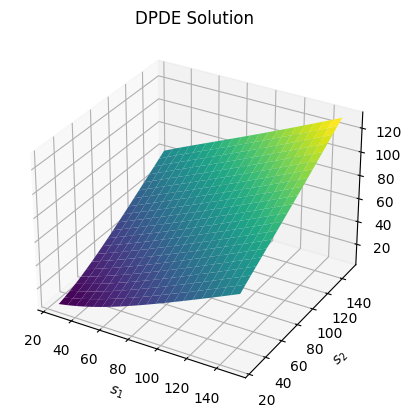

In [58]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, DPDE_solution, cmap='viridis')
ax.set_title('DPDE Solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

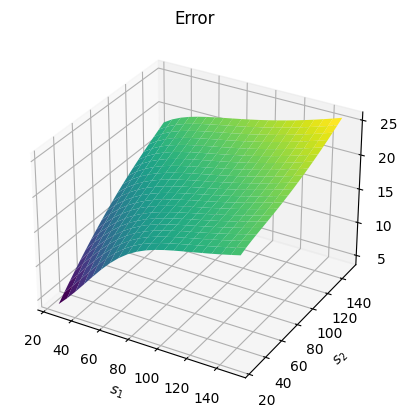

In [59]:
fifig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(DPDE_solution - exact_solution_evaluated)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

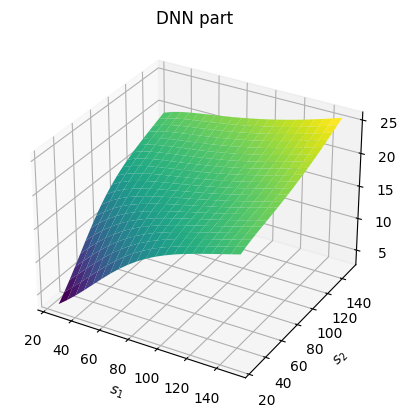

In [60]:
fig = plt.figure()
ax = plt.axes(projection='3d')

dnn_part = DPDE_solution - localisation_plot
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, dnn_part, cmap='viridis')
ax.set_title('DNN part')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

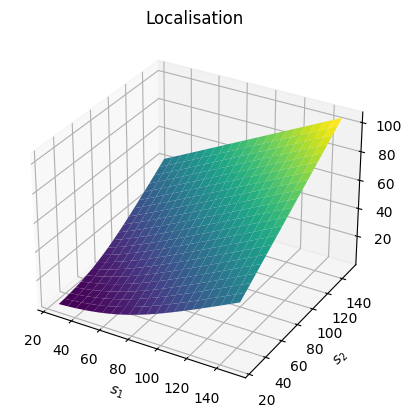

In [61]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, localisation_plot, cmap='viridis')
ax.set_title('Localisation')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

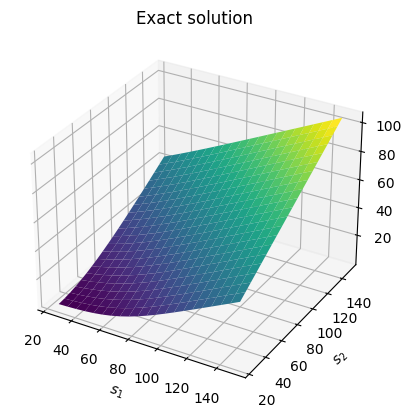

In [62]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(s1_plot_mesh, s2_plot_mesh, exact_solution_evaluated, cmap='viridis')
ax.set_title('Exact solution')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

### Volatilié implicite

In [63]:
Implied_Volatility_Explicit = [Implied_Volatility_bis(Price=exact_solution(t=t_max, s1=s1[0], s2=s2[0], 
                                riskfree_rate=riskfree_rate_eval, 
                                volatility1=volatility1_eval, 
                                volatility2=volatility2_eval,
                                correlation=correlation_eval),S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_Explicit = np.array(Implied_Volatility_Explicit)
Implied_Volatility_Explicit = Implied_Volatility_Explicit.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

In [64]:
Implied_Volatility_DPDE = [Implied_Volatility_bis(Price=
                                              model.predict(np.array([normalise.normalise_time(t_max), normalise.normalise_logprice(np.log(s1[0])),
                                              normalise.normalise_logprice(np.log(s2[0])), normalise.normalise_riskfree_rate(riskfree_rate_eval), 
                                              normalise.normalise_volatility(volatility1_eval), normalise.normalise_volatility(volatility2_eval), 
                                              normalise.normalise_correlation(correlation_eval)]).reshape(1,7))[0][0]
                                              ,S=0.5*(s1[0]+s2[0]),strike_price=100,riskfree_rate=riskfree_rate_eval,T=4)
                  for s1, s2 in zip(
                      s1_plot_mesh.reshape(-1, 1), s2_plot_mesh.reshape(-1, 1))]

Implied_Volatility_DPDE = np.array(Implied_Volatility_DPDE)
Implied_Volatility_DPDE = Implied_Volatility_DPDE.reshape(
    nr_samples_surface_plot, nr_samples_surface_plot)

### Erreur entre vol implicit exact price et PDE price 

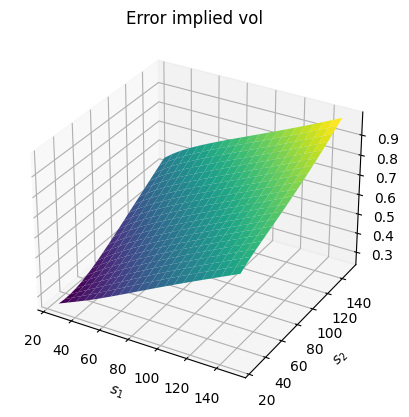

In [65]:
fig = plt.figure()
ax = plt.axes(projection='3d')

error = np.abs(Implied_Volatility_DPDE - Implied_Volatility_Explicit)
ax.plot_surface(s1_plot_mesh, s2_plot_mesh, error, cmap='viridis')
ax.set_title('Error implied vol')
ax.set_xlabel('$s_1$')
ax.set_ylabel('$s_2$')
plt.show()

Text(0, 0.5, 'DPDE Error')

<Figure size 1000x1000 with 0 Axes>

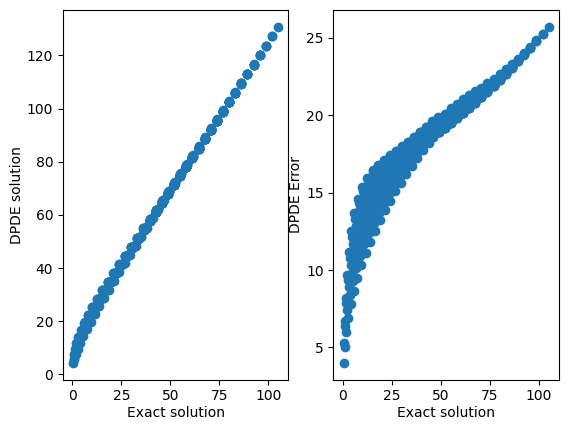

In [66]:
f = plt.figure(figsize=(10,10))    
f, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].scatter(exact_solution_evaluated, DPDE_solution)
axes[0].set_xlabel('Exact solution', labelpad = 2)
axes[0].set_ylabel('DPDE solution', labelpad = 2)


axes[1].scatter(exact_solution_evaluated, np.abs(exact_solution_evaluated - DPDE_solution))
axes[1].set_xlabel('Exact solution', labelpad = 2)
axes[1].set_ylabel('DPDE Error', labelpad = 2)


Text(0, 0.5, 'DPDE Relative Error')

<Figure size 1000x1000 with 0 Axes>

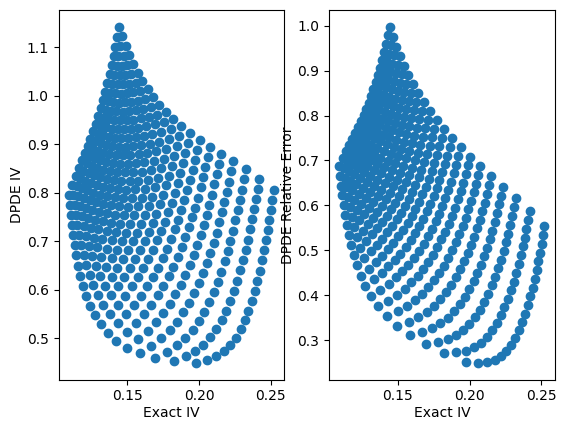

In [67]:
f = plt.figure(figsize=(10,10))    
f, axes = plt.subplots(nrows = 1, ncols = 2)
axes[0].scatter(Implied_Volatility_Explicit, Implied_Volatility_DPDE)
axes[0].set_xlabel('Exact IV', labelpad = 2)
axes[0].set_ylabel('DPDE IV', labelpad = 2)


axes[1].scatter(Implied_Volatility_Explicit, np.abs(Implied_Volatility_Explicit - Implied_Volatility_DPDE))
axes[1].set_xlabel('Exact IV', labelpad = 2)
axes[1].set_ylabel('DPDE Relative Error', labelpad = 2)

## Assets d=3

In [68]:
dim_states =3  
dim_parameter =4 #equal correlation
dim_totale= 1+ dim_states +dim_parameter




In [69]:
sigm_eval = np.random.uniform(0.08, 0.3, dim_states**2).reshape((dim_states,dim_states))
correlation_eval = np.array([1., 0.3, 0.3, 0.3, 1., 0.3, 0.3, 0.3, 1. ]).reshape((dim_states, dim_states))
